In [14]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
data_path = "data/2019_06_17_16_28_47"

tcm_raw = pd.read_csv( data_path+"tcm.csv")
vnav_raw = pd.read_csv( data_path+"vnav.csv")
yost_raw = pd.read_csv( data_path+"yost.csv")

all_raw = [tcm_raw, vnav_raw, yost_raw]

## Fixup missing time column in yostlabs for now
# yost_raw["Time"] = tcm_raw["Time"]

In [25]:
## Normalize all times and set time as index

t0 = min( [ f["Time"].min() for f in all_raw] )

for f in all_raw:
    f["Time"] = f["Time"]-t0
    f.set_index("Time", inplace=True)

## TODOS:

* Vectornav: Figure out column labels, ensure correct number of column labels in csv file
* Yost Labs: Data inconsistent
* TCM:  Add magnetometer/compass data

In [26]:
tcm_raw.head(5)

,ax,ay,az
Time,,,
0.000,-0.006785,0.046616,-4.547351
0.078,-0.006775,0.046614,-4.547331
0.169,-0.006782,0.046627,-4.547310
0.284,-0.006716,0.046631,-4.547248
0.385,-0.006693,0.046642,-4.547225


In [27]:
vnav_raw.head(5)

,yaw,pitch,roll,magx,magy,magz,accelx,accely,accelz,gyrox,gyroy,gyroz
Time,,,,,,,,,,,,
0.006,41.988,-4.480,-0.385,0.1563,-0.2142,0.3906,-0.790,0.071,-9.758,0.000978,0.000269,-0.000775
0.083,41.997,-4.478,-0.386,0.1564,-0.2097,0.3965,-0.749,0.075,-9.798,-0.000849,0.001461,0.000272
0.186,42.021,-4.484,-0.390,0.1564,-0.2098,0.3953,-0.715,0.063,-9.746,0.000370,-0.000929,0.000404
0.287,42.015,-4.483,-0.389,0.1554,-0.2098,0.3929,-0.745,0.067,-9.750,0.000771,0.000734,-0.000314
0.389,42.015,-4.483,-0.391,0.1564,-0.2087,0.3917,-0.780,0.074,-9.763,-0.000375,0.000215,0.000646


In [28]:
yost_raw.head(5)

,quat 1,quat 2,quat 3,quat 4
Time,,,,
0.098,-0.998230,-0.015672,0.053333,-0.021150
0.212,-0.998232,-0.015546,0.053320,-0.021149
0.311,-0.998232,-0.015518,0.053327,-0.021163
0.420,-0.998234,-0.015542,0.053302,-0.021142
0.527,-0.998234,-0.015673,0.053275,-0.021115


<Figure size 432x288 with 0 Axes>

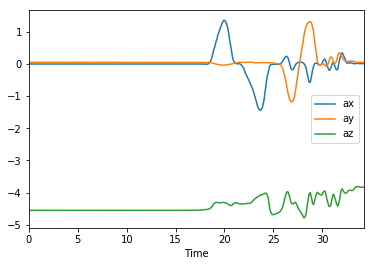

In [29]:
plt.figure()
tcm_raw.plot()

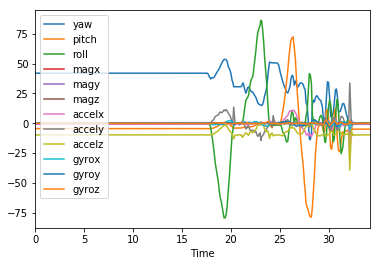

In [30]:
vnav_raw.plot()

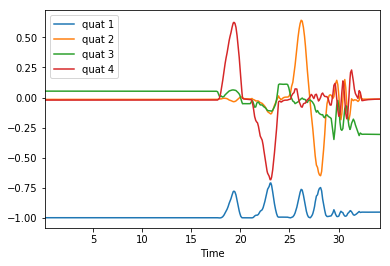

In [31]:
yost_raw.plot()